In [ ]:
#@title Implementação dos modelos em Python
#@markdown Esta célula contém a implementação em Python 3 dos principais modelos de computação vistos na disciplina de Linguagens Formais e Autômatos. 
#@markdown Não é necessário conhecer o código aqui implementado ou mesmo ter um conhecimento profundo da linguagem Python. Acompanhe os exemplos e experimente construir seus próprios modelos.
 
#@markdown >*Execute esta célula (`ctrl+enter` ou clicando no botão ao lado) para que o ambiente seja carregado com as classes implementadas.*
 
from graphviz import Digraph
import re
 
class AP: 
    def __init__(self, Q={}, Sigma={}, Gamma={}, delta={}, q0=0, F={}):
        self.states = Q
        self.inputAlphabet = Sigma
        self.stackAlphabet = Gamma
        self.transition = delta
        self.startState = q0
        self.acceptStates = F 
 
        self.initialize()
 
    def initialize(self, input_string=""):
        self.traces = [[(self.startState,tuple(input_string),())]]
 
    def check(self):
        pass
        
    def hasNext(self):
        return self.traces and (not self.acceptTraces())
    
    def acceptTraces(self):
        return [t for t in self.traces if t[-1][1] == () and t[-1][0] in self.acceptStates]
 
    def step(self):
        updated_traces = []
        for trace in self.traces:
          s, string, stack = trace[-1]
          A = {'', string[0]} if string else {''}
          B = {'', stack[-1]} if stack else {''}
          possible_transitions = [(s,a,b) for a in A for b in B if (s,a,b) in self.transition]          
          for (s,a,b) in possible_transitions:  
            for r,c in self.transition[s,a,b]:
              nstring = string[1:] if a else string
              nstack  = stack[:-1] if b else stack
              nstack  = nstack+(c,) if c else nstack
              if (not (r,nstring,nstack) in trace):
                updated_traces.append(trace+[(r,nstring,nstack)])
        self.traces = updated_traces
 
    def run(self, input_string=0, max_steps=1000):        
        while (self.hasNext()): 
          if max_steps == 0: 
            raise Exception("Timeout")
          self.step()
          max_steps -= 1
        return self.result()
 
    def aceita(self, input_string=0):
        self.initialize(input_string)
        return self.run()
 
    def result(self):
        return True if self.acceptTraces() else (False if (not self.traces) else None)
    
    def visualizar(self):      
        f = Digraph('finite_state_machine', filename='fsm.gv')
        f.attr(rankdir='LR', size='8,5')
 
        f.attr('node', shape='point')
        f.node('')
        
        f.attr('node', shape='doublecircle')
        for n in self.acceptStates:
          f.node(str(n))
 
        f.attr('node', shape='circle')
        for n in self.states.difference(self.acceptStates):
          f.node(str(n))
 
        label = {}        
        for (q,a,b) in self.transition:
          for (r,c) in self.transition[q,a,b]:          
            label[q,r] = label[q,r]+[(a,b,c)] if (q,r) in label else [(a,b,c)]
 
        f.edge('', str(self.startState))
        for (q,r) in label:
          f.edge(str(q),str(r),label=self.graphviz_edge_label_format(label[q,r]))      
          pass
        
        return f
    
    def graphviz_edge_label_format(self,labels=[]):
        epsilon = "\u03BB"
        right_arrow = "\u2192"
        return '\n'.join([(a if (a or a==0) else epsilon) + "," + (b if (b or b==0) else epsilon) + right_arrow + (c if (c or c==0) else epsilon) for (a,b,c) in labels])
        # return '\n'.join([(str(a) if a else epsilon) + "," + (str(b) if b else epsilon) + right_arrow + (str(c) if c else epsilon) for (a,b,c) in labels])
 
class AFN(AP):
  def __init__(self, Q={}, Sigma={}, delta={}, q0=0, F={}):
        delta_pda = {}
        for q,a in delta:
          delta_pda[q,a,''] = {(r,'') for r in delta[q,a]}
        super().__init__(Q,Sigma,{},delta_pda,q0,F)
  
  def graphviz_edge_label_format(self,labels):
      epsilon = "\u03B5"
      return ",".join([(str(a) if (a or a==0) else epsilon) for (a,b,c) in labels])
 
class AFD(AFN):
  def __init__(self, Q={}, Sigma={}, delta={}, q0=0, F={}):
        delta_nfa = {}
        for (q,a) in delta:
          delta_nfa[q,a] = {delta[q,a]}
        super().__init__(Q,Sigma,delta_nfa,q0,F)
 
class ER:
  def __init__(self,regex=None):  
    if (regex == None):
      self.regex = None
    elif (re.match("^[a-zA-Z0-9\(\)\|\*]*$", regex)):
      self.regex = regex
    else:
      raise Exception("Invalid pattern")
 
  def gera(self, input_string):
    if (self.regex == None):
      return False
    else:
      return True if re.match("^"+self.regex+"$",input_string) else False
 
class GLC:
  def __init__(self,V,Sigma,R,S):
      self.variables = V
      self.terminals = Sigma
      # self.rules = R
      self.rules = {(a, tuple(b)) for (a,b) in R}
      self.start = S
 
      self.derivation = []
      self.chomsky = None
  
  def gera(self, string):
      if (not self.chomsky):
        self.chomsky = self.to_chomsky()        
      G = self.chomsky
      
      if len(string) == 0: return (G.start,()) in G.rules
 
      # CYK Algorithm
      n = len(string)
      P = [[[] for x in range(n - y)] for y in range(n)]
      for i,c in enumerate(string):
        for v in [a for (a,b) in G.rules if len(b) == 1 and c in b]:
          P[0][i] += [v]
      for l in range(2, n+1): # borda da iteração
        for s in range(0, n+1-l): # coluna
          for p in range(1, l): # linha
            for u, v in [(a,b) for (a,b) in G.rules if len(b) == 2]:
              if v[0] in P[p-1][s] and v[1] in P[l-p-1][s+p]:
                P[l-1][s] += [u]
      return G.start in P[-1][0]
 
  def print(self):
      rightarrow = "\u2192"
      print(self.start,rightarrow, '|'.join([''.join(y) for x,y in self.rules if x == S]))
      for v in sorted(self.variables.difference(self.start)): 
        print(v,rightarrow, '|'.join([''.join(y) for x,y in self.rules if x == v]))
 
  def replace_eps(self, v, l):
    if not l: return {()}
    result = {(l[0],) + s for s in self.replace_eps(v, tuple(l[1:]))}
    if l[0] == v:
      result.update({tuple(s[1:]) for s in result})
    return result   
 
  def to_chomsky(self):
      n_state = 0
      
      S = '<{}>'.format(n_state)
      Sigma = self.terminals 
      V = {S}.union(self.variables)
      R = {(S,(self.start,))}.union(self.rules)
 
      target = {alpha for alpha in self.variables if (alpha,()) in R}
      while (target):
        for e in target:
          rules = {(alpha,beta) for (alpha,beta) in R if e in beta}
          for (a,b) in rules:
            R.update({(a, beta) for beta in self.replace_eps(e,b)})
          R.discard((e,()))
        target = {alpha for alpha in self.variables if (alpha,()) in R}
      
      target = {(a,b) for (a,b) in R if len(b) == 1 and b[0] in V}
      while (target):
        for u,v in target:
          rules = {b for (a,b) in R if a == v[0]}
          R.update({(u,b) for b in rules})
          R.discard((u,v))
        target = {(a,b) for (a,b) in R if len(b) == 1 and b[0] in V}
      
      target = {(alpha,beta) for (alpha,beta) in R if len(beta) > 2}
      while(target):
        for u,v in target:
          n_state += 1
          state = '<{}>'.format(n_state)
          V.update({state})
          R.update({(u,(v[0],state)),(state, tuple(v[1:]))})
          R.discard((u,v))
        target = {(alpha,beta) for (alpha,beta) in R if len(beta) > 2}
 
      target = {(alpha,beta) for (alpha,beta) in R if len(beta) == 2}
      for u,v in target:
        n = list(v)
        for i in range(2):
          if v[i] in Sigma:
            R.discard((u,(n[0],n[1])))
            n_state += 1
            n[i] = '<{}>'.format(n_state)
            V.update({n[i]})
            R.update({(u,(n[0],n[1]))})
            R.update({(n[i],(v[i],))})
 
      return GLC(V,Sigma,R,S)

# Exercícios

1. Construa uma máquina de Mealy que recebe uma palavra de entrada com alfabeto $\Sigma=\{0,1\}$ e substitui a primeira ocorrência de 1 por um 0 para toda subsequência de 1. Por exemplo, a palavra w = 0001001110 tornar-se-ia w = 0000000110.      

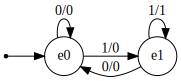

In [ ]:
Q = {"e0", "e1"}
Sigma = {"0", "1"}
Delta = {
    ("e0", "0/0"): "e0",
    ("e0", "1/0"): "e1",
    ("e1", "1/1"): "e1",
    ("e1", "0/0"): "e0",
}
q0 = "e0"
F = {}

afd = AFD(Q, Sigma, Delta, q0, F)
afd.visualizar()

2. Resolva o mesmo problema do exercício anterior, desta vez, considere uma máquina de Moore.

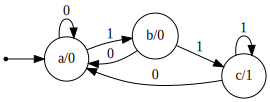

In [ ]:
Q = {"a/0", "b/0", "c/1"}
Sigma = {"0", "1"}
Delta = {
    ("a/0", "1"): "b/0",
    ("a/0", "0"): "a/0",
    ("b/0", "0"): "a/0",
    ("b/0", "1"): "c/1",
    ("c/1", "0"): "a/0",
    ("c/1", "1"): "c/1",
}
q0 = "a/0"
F = {}

afd = AFD(Q, Sigma, Delta, q0, F)
afd.visualizar()

3. Construa uma máquina de Moore com alfabeto de entrada $\Sigma=\{0,1\}$ e alfabeto de saída $\Delta=\{S,N\}$ que produza saída S se a palavra de entrada contém a subsequência 1010, caso contrário, produza N como saída.

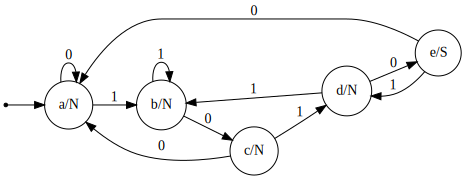

In [ ]:
Q = {"a/N", "b/N", "c/N", "d/N", "e/S"}
Sigma = {"0", "1"}
Delta = {
    ("a/N", "1"): "b/N",
    ("a/N", "0"): "a/N",
    ("b/N", "1"): "b/N",
    ("b/N", "0"): "c/N",
    ("c/N", "1"): "d/N",
    ("c/N", "0"): "a/N",
    ("d/N", "1"): "b/N",
    ("d/N", "0"): "e/S",
    ("e/S", "1"): "d/N",
    ("e/S", "0"): "a/N",
}
q0 = "a/N"
F = {}

afd = AFD(Q, Sigma, Delta, q0, F)
afd.visualizar()

4. Resolva o mesmo problema do exercício anterior, desta vez, considere uma máquina de Mealy.

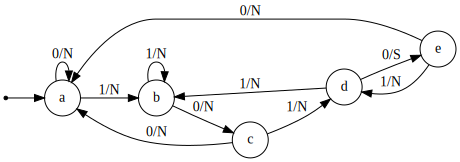

In [ ]:
Q = {"a", "b", "c", "d", "e"}
Sigma = {"0", "1"}
Delta = {
    ("a", "0/N"): "a",
    ("a", "1/N"): "b",
    ("b", "0/N"): "c",
    ("b", "1/N"): "b",
    ("c", "0/N"): "a",
    ("c", "1/N"): "d",
    ("d", "0/S"): "e",
    ("d", "1/N"): "b",
    ("e", "0/N"): "a",
    ("e", "1/N"): "d",
}
q0 = "a"
F = {}

afd = AFD(Q, Sigma, Delta, q0, F)
afd.visualizar()